# Kuzushiji-MNIST Data Classification by CNN Model

The notebook demostrates how to:

1. Upload the KMNIST image datasets to the S3 bucket
2. Train the convolutional nueral network model using the high-spec cloud computing resources
3. Host the trained model at the HTTPS endpoint

so that you are capable of classifying several Hiragana characters. This notebook runs on your local machine once your set up the appropriate credentials and install the required packages/libraries as mentioned in the [README](https://github.com/stmsy/sagemaker) page.

In [1]:
import os
from pathlib import Path
import warnings
warnings.simplefilter('ignore')

import boto3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sagemaker
from sagemaker import get_execution_role
from sagemaker.session import s3_input
from sagemaker.tensorflow import TensorFlow
from sagemaker.tensorflow.serving import Predictor
from tensorflow.python.keras.utils import to_categorical
import yaml

from entry_points.kmnist_cnn import (DATA_DIR, KMNIST_DATA_DIR, NUM_CLASSES, PWD, 
                                     TEST_DATA_OFFSET, preprocess_images)

plt.rcParams['font.family'] = 'IPAPGothic'  # TO-DO: Check detail and decide to remove or not
%matplotlib inline

In [2]:
SETTINGS_YML = PWD.joinpath('..', '..', 'settings.yml')

In [3]:
with SETTINGS_YML.open() as f:
    SETTINGS = yaml.load(f)

## AWS Account, Role and Misc Config

As of `2019-10-08`, `sagemaker.get_execution_role()` fails to be executed properly and raises `ValueError`. So the SageMaker role must be set manually to use the computing resources on the cloud.

In [4]:
# AWS account and SageMaker role info
try:
    ROLE = get_execution_role()
except ValueError:
    AWS_ACCOUNT_ID = SETTINGS['sagemaker']['account_id']
    ROLE_NAME = SETTINGS['sagemaker']['role_name']
    ROLE = f'arn:aws:iam::{AWS_ACCOUNT_ID}:role/service-role/{ROLE_NAME}'

# Data location at S3
PREFIX = 'sagemaker/kmnist'

Couldn't call 'get_role' to get Role ARN from role name m-sato to get Role path.


## Create Session to Access S3 Bucket

Access S3 with the default bucket for the tutorial as `sagemaker.Session()` allocates it initially tied to your AWS/SageMaker account or otherwise specify `BUCKET_NAME` properly.

In [5]:
SESS = sagemaker.Session()

In [6]:
BUCKET_NAME = SESS.default_bucket()

In [7]:
S3 = boto3.resource('s3')
BUCKET = S3.Bucket(BUCKET_NAME)

print(BUCKET.name)

sagemaker-us-east-1-540801573371


Define the snippets to download from and upload to the S3 bucket.

In [8]:
def _get_dst_filepath(prefix: str, src_filepath: Path, dst_dir: str) -> str:
    """Get filepath in S3 bucket."""
    return os.path.join(prefix, dst_dir, src_filepath.name)


def _get_src_filepath(prefix: str, src_dir: str, src_filename: str) -> str:
    """Get filepath in S3 bucket."""
    return os.path.join(prefix, src_dir, src_filename)


def upload_data(prefix: str, src_filepath: Path, dst_dir: str) -> None:
    """Upload data to S3 bucket."""
    dst_filepath = _get_dst_filepath(prefix, src_filepath, dst_dir)
    obj = BUCKET.Object(dst_filepath)
    obj.upload_file(str(src_filepath))
    
    
def download_data(prefix: str, src_dir: str, src_filename: str, 
                  dst_dir: Path) -> None:
    """Download data from S3 bucket."""
    src_filepath = _get_src_filepath(prefix, src_dir, src_filename)
    obj = BUCKET.Object(src_filepath)
    obj.download_file(str(dst_dir.joinpath(src_filename)))

## Store Datasets in Local Directory and S3 Bucket

Download the datasets in uncompressed `.npz` format from the [KMNIST](https://github.com/rois-codh/kmnist) GitHub page to local directory and upload them to the S3 bucket.

In [9]:
X_TRAIN_NPZ = KMNIST_DATA_DIR.joinpath('kmnist-train-imgs.npz')
Y_TRAIN_NPZ = KMNIST_DATA_DIR.joinpath('kmnist-train-labels.npz')
X_TEST_NPZ = KMNIST_DATA_DIR.joinpath('kmnist-test-imgs.npz')
Y_TEST_NPZ = KMNIST_DATA_DIR.joinpath('kmnist-test-labels.npz')

In [10]:
CLASSMAP_CSV = KMNIST_DATA_DIR.joinpath('kmnist_classmap.csv')

In [11]:
if not KMNIST_DATA_DIR.exists():
    KMNIST_DATA_DIR.mkdir(parents=True)
  
for filepath in [X_TRAIN_NPZ, Y_TRAIN_NPZ, X_TEST_NPZ, Y_TEST_NPZ, CLASSMAP_CSV]:
    if not filepath.exists():
        filename = filepath.name
        url = 'http://codh.rois.ac.jp/kmnist/dataset/kmnist/' + filename
        !curl --output $filepath $url  # Download to local directory
        if 'classmap' not in filename:
            learning_stage = filename.split('-')[1]  # Either 'train' or 'test'
            upload_data(PREFIX, filepath, learning_stage)  # Upload to S3 Bucket

## Load and Visualize KMNIST Data

Like the MNIST dataest of the handwritten digits, the KMNIST dataset contains a collection of 10 distinct Hiragana characters out of 49: `お`, `き`, `す`, `つ`, `な`, `は`, `ま`, `や`, `れ`, and `を`.

In [12]:
df_classes = pd.read_csv(CLASSMAP_CSV).set_index('index')

df_classes.head()

,codepoint,char
index,,
0,U+304A,お
1,U+304D,き
2,U+3059,す
3,U+3064,つ
4,U+306A,な


In [13]:
classes = df_classes.to_dict()['char']
classes

{0: 'お',
 1: 'き',
 2: 'す',
 3: 'つ',
 4: 'な',
 5: 'は',
 6: 'ま',
 7: 'や',
 8: 'れ',
 9: 'を'}

In [14]:
# Load test data
X_test = np.load(X_TEST_NPZ)['arr_0']
y_test = np.load(Y_TEST_NPZ)['arr_0']

In [15]:
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

X_test.shape: (10000, 28, 28)
y_test.shape: (10000,)


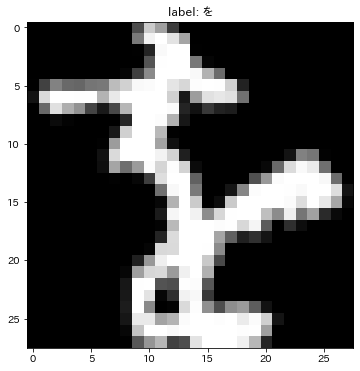

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(X_test[84], cmap='gray')
ax.grid(False)
ax.set_title(f"label: {classes[y_test[84]]}")
fig.show()

### お

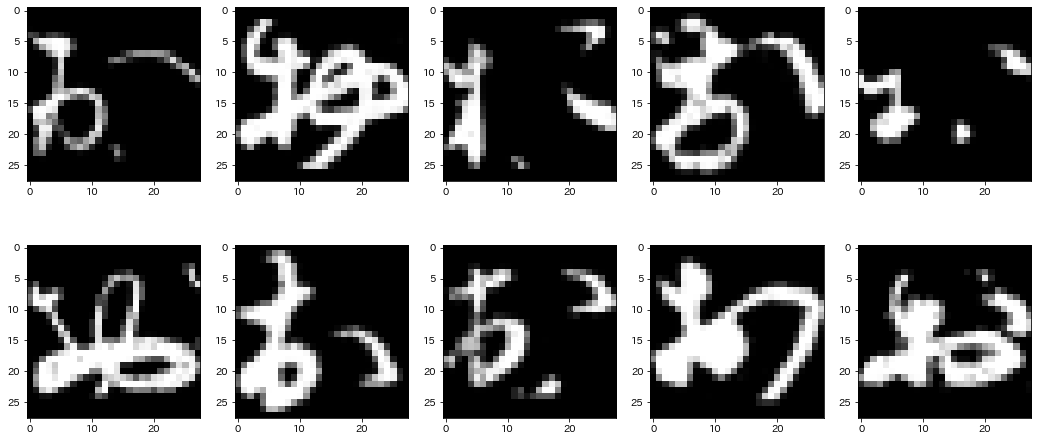

In [17]:
X_test_0 = X_test[y_test == 0]

nrows, ncols = 2, 5
fig, ax = plt.subplots(nrows, ncols, figsize=(18, 8))
for i in range(nrows * ncols):
    ax[i // ncols, i % ncols].imshow(X_test_0[i], cmap='gray')
fig.show()

### き

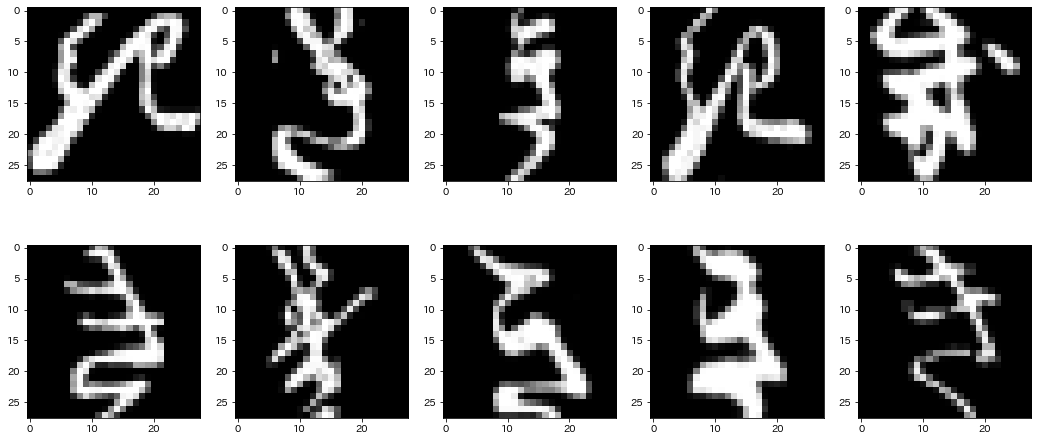

In [18]:
X_test_1 = X_test[y_test == 1]

nrows, ncols = 2, 5
fig, ax = plt.subplots(nrows, ncols, figsize=(18, 8))
for i in range(nrows * ncols):
    ax[i // ncols, i % ncols].imshow(X_test_1[i], cmap='gray')
fig.show()

### す

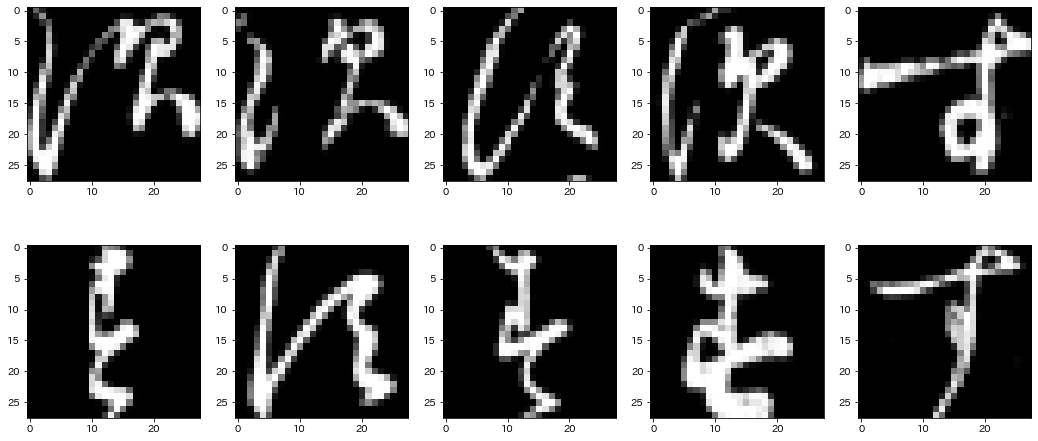

In [19]:
X_test_2 = X_test[y_test == 2]

nrows, ncols = 2, 5
fig, ax = plt.subplots(nrows, ncols, figsize=(18, 8))
for i in range(nrows * ncols):
    ax[i // ncols, i % ncols].imshow(X_test_2[i], cmap='gray')
fig.show()

### つ

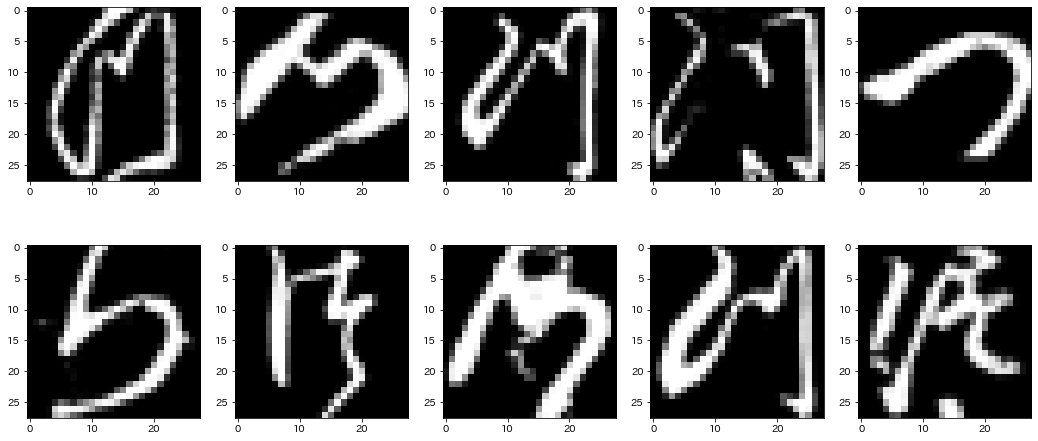

In [20]:
X_test_3 = X_test[y_test == 3]

nrows, ncols = 2, 5
fig, ax = plt.subplots(nrows, ncols, figsize=(18, 8))
for i in range(nrows * ncols):
    ax[i // ncols, i % ncols].imshow(X_test_3[i], cmap='gray')
fig.show()

### な

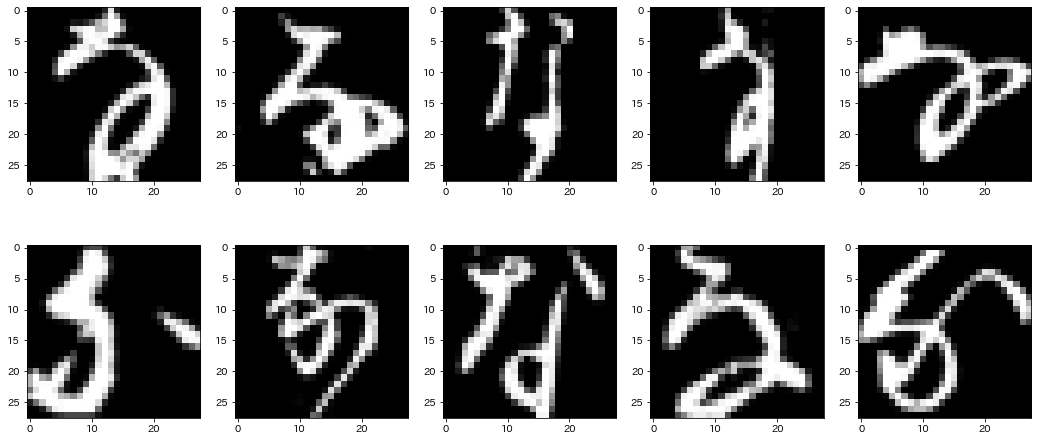

In [21]:
X_test_4 = X_test[y_test == 4]

nrows, ncols = 2, 5
fig, ax = plt.subplots(nrows, ncols, figsize=(18, 8))
for i in range(nrows * ncols):
    ax[i // ncols, i % ncols].imshow(X_test_4[i], cmap='gray')
fig.show()

### は

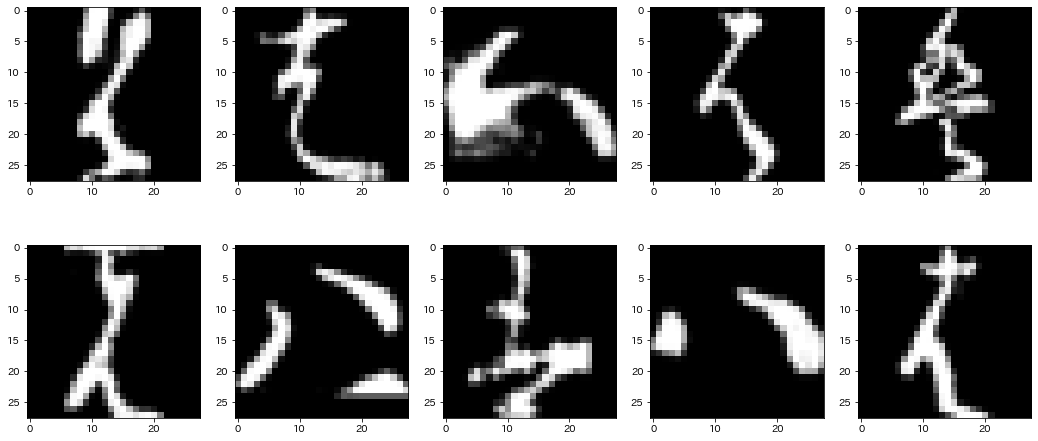

In [22]:
X_test_5 = X_test[y_test == 5]

nrows, ncols = 2, 5
fig, ax = plt.subplots(nrows, ncols, figsize=(18, 8))
for i in range(nrows * ncols):
    ax[i // ncols, i % ncols].imshow(X_test_5[i], cmap='gray')
fig.show()

### ま

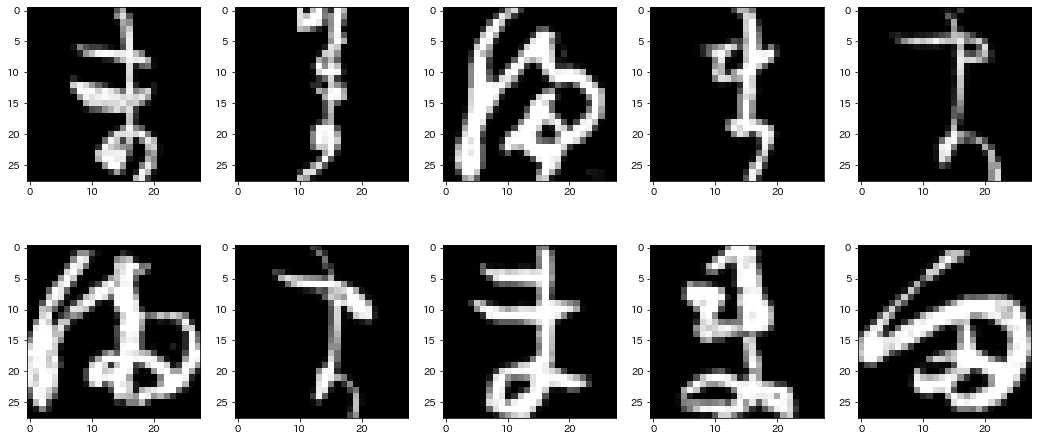

In [23]:
X_test_6 = X_test[y_test == 6]

nrows, ncols = 2, 5
fig, ax = plt.subplots(nrows, ncols, figsize=(18, 8))
for i in range(nrows * ncols):
    ax[i // ncols, i % ncols].imshow(X_test_6[i], cmap='gray')
fig.show()

### や

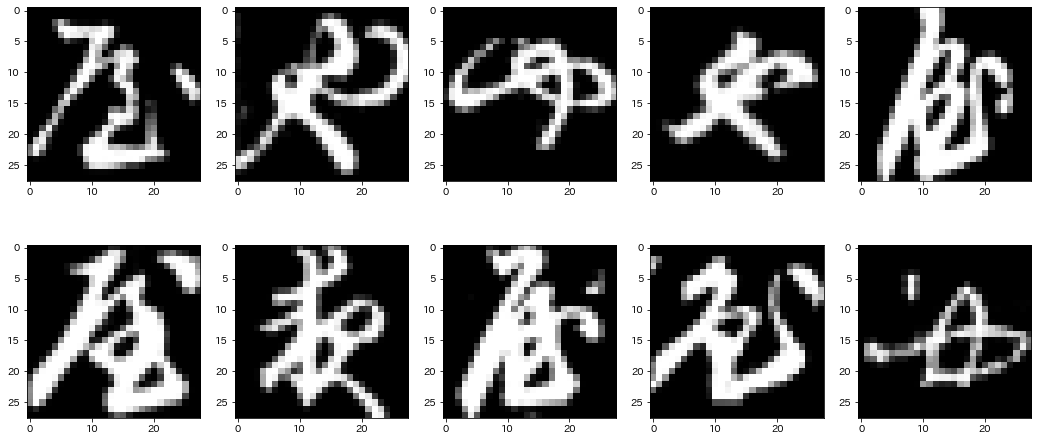

In [24]:
X_test_7 = X_test[y_test == 7]

nrows, ncols = 2, 5
fig, ax = plt.subplots(nrows, ncols, figsize=(18, 8))
for i in range(nrows * ncols):
    ax[i // ncols, i % ncols].imshow(X_test_7[i], cmap='gray')
fig.show()

### れ

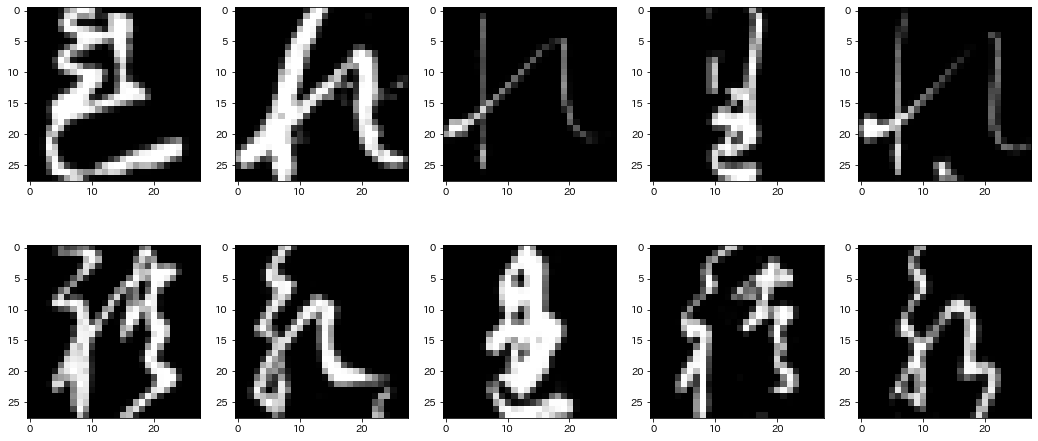

In [25]:
X_test_8 = X_test[y_test == 8]

nrows, ncols = 2, 5
fig, ax = plt.subplots(nrows, ncols, figsize=(18, 8))
for i in range(nrows * ncols):
    ax[i // ncols, i % ncols].imshow(X_test_8[i], cmap='gray')
fig.show()

### を

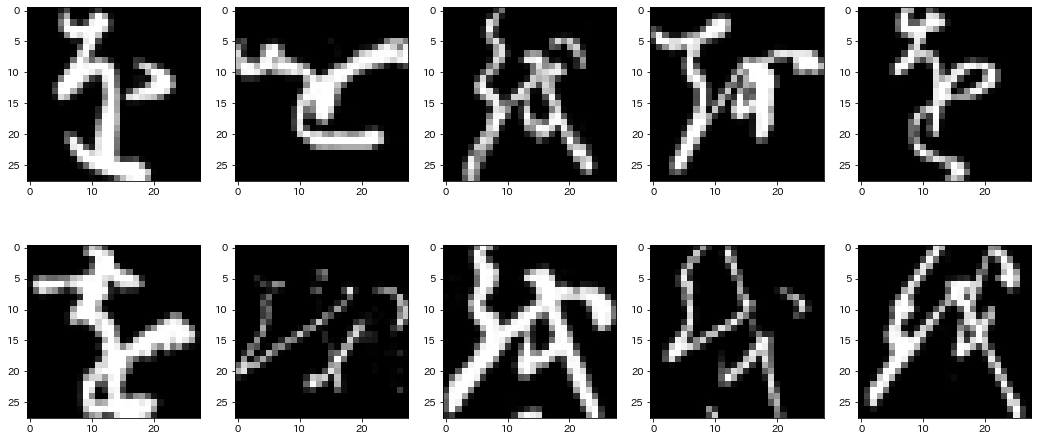

In [26]:
X_test_9 = X_test[y_test == 9]

nrows, ncols = 2, 5
fig, ax = plt.subplots(nrows, ncols, figsize=(18, 8))
for i in range(nrows * ncols):
    ax[i // ncols, i % ncols].imshow(X_test_9[i], cmap='gray')
fig.show()

## Train the Model on SageMaker Instances

Train on one or more the SageMaker instances the simple convolutional neural network model implemented by the TensorFlow-backended Keras. For training, the `estimator` must be created with the following minimal configuration:

1. `entry_point`: Python script to be used as entry point of the `estimator`
2. `role`: SageMaker role assigned to your account
3. `train_instance_count`: number to instances to use for training
4. `train_instance_type`: type of instances to use for training
5. `framework_version`: TensorFlow version in your runtime environment
6. `py_version`: Python version used in your runtime environment
7. `script_mode`: Whether or not the script mode is used for the `estimator`

More information is available at [TensorFlow Estimator](https://sagemaker.readthedocs.io/en/stable/sagemaker.tensorflow.html).

In [27]:
ENTRY_POINT = str(PWD.joinpath('entry_points', 'kmnist_cnn.py'))

Originally the pixel values of each image data range from `0` to `255`. The entry point `kmnist_cnn.py` normalizes them in between `0.0` and `1.0` and reshape the tensor (the collection of all the image data) so that they are compatible with the machine learning models.

```python
def _normalize_images(X: np.ndarray) -> np.ndarray:
    """Normalize the pixel values (0 to 255) in between 0 to 1."""
    return X / 255


def _reshape_images(X: np.ndarray) -> np.ndarray:
    """Reshape and convert the collection of matrices to the one of vectors."""
    return X.reshape(X.shape + (1,))


def preprocess_images(X: np.ndarray, reshape: bool = False) -> np.ndarray:
    """Normalize and reshape images."""
    X = _normalize_images(X)
    if reshape:
        X = _reshape_images(X)
    return X
```

In [28]:
TRAIN_INSTANCE_COUNT = SETTINGS['instance']['train']['count']
TRAIN_INSTANCE_TYPE = SETTINGS['instance']['train']['type']

In [29]:
estimator = TensorFlow(entry_point=ENTRY_POINT, role=ROLE, 
                       train_instance_count=TRAIN_INSTANCE_COUNT, 
                       train_instance_type=TRAIN_INSTANCE_TYPE,
                       framework_version='1.13.1', py_version='py3', 
                       script_mode=True)

All the training data stored in S3 will be used to train the model, some portion of test data for validation.

In [30]:
s3_train_path = f's3://{BUCKET.name}/{PREFIX}/train'
s3_test_path = f's3://{BUCKET.name}/{PREFIX}/test'

In [31]:
estimator.fit(
    inputs={'train': s3_input(s3_train_path), 'test': s3_input(s3_test_path)}, 
    logs=False
)


2020-05-20 08:38:06 Starting - Starting the training job
2020-05-20 08:38:10 Starting - Launching requested ML instances...................
2020-05-20 08:39:55 Starting - Preparing the instances for training............................
2020-05-20 08:42:30 Downloading - Downloading input data.....
2020-05-20 08:43:00 Training - Downloading the training image...
2020-05-20 08:43:21 Training - Training image download completed. Training in progress..................................................................................................................
2020-05-20 08:53:25 Uploading - Uploading generated training model
2020-05-20 08:53:31 Completed - Training job completed


## Check Perfomance of the Trained Model with Several Test Images

After finished training, send the test data in your local machine to the HTTPS endpoint hosting where the trained model is deployed.

In [32]:
INITIAL_INSTANCE_COUNT = SETTINGS['instance']['endpoint']['count']
INSTANCE_TYPE = SETTINGS['instance']['endpoint']['type']
ENDPOINT_NAME = SETTINGS['instance']['endpoint']['name']

In [33]:
predictor = estimator.deploy(initial_instance_count=INITIAL_INSTANCE_COUNT, 
                             instance_type=INSTANCE_TYPE, 
                             endpoint_name=ENDPOINT_NAME)

-----------------------------------------------------------------------------------!

In [34]:
X_test = X_test[TEST_DATA_OFFSET:]
X_test = preprocess_images(X_test, reshape=True)  # Normalize and reshape

y_test = y_test[TEST_DATA_OFFSET:]

In [35]:
def get_y_pred(predictor: Predictor, X_test: np.ndarray) -> int:
    """Predict label for test dataset."""
    X_test_reshaped = X_test.reshape((1,) + X_test.shape)
    return np.argmax(predictor.predict(X_test_reshaped)['predictions'][0])

Predict the label from the 20 images from test data unused for validation at the training stage.

In [36]:
y_pred = [get_y_pred(predictor, X_test[i]) for i in range(20)]

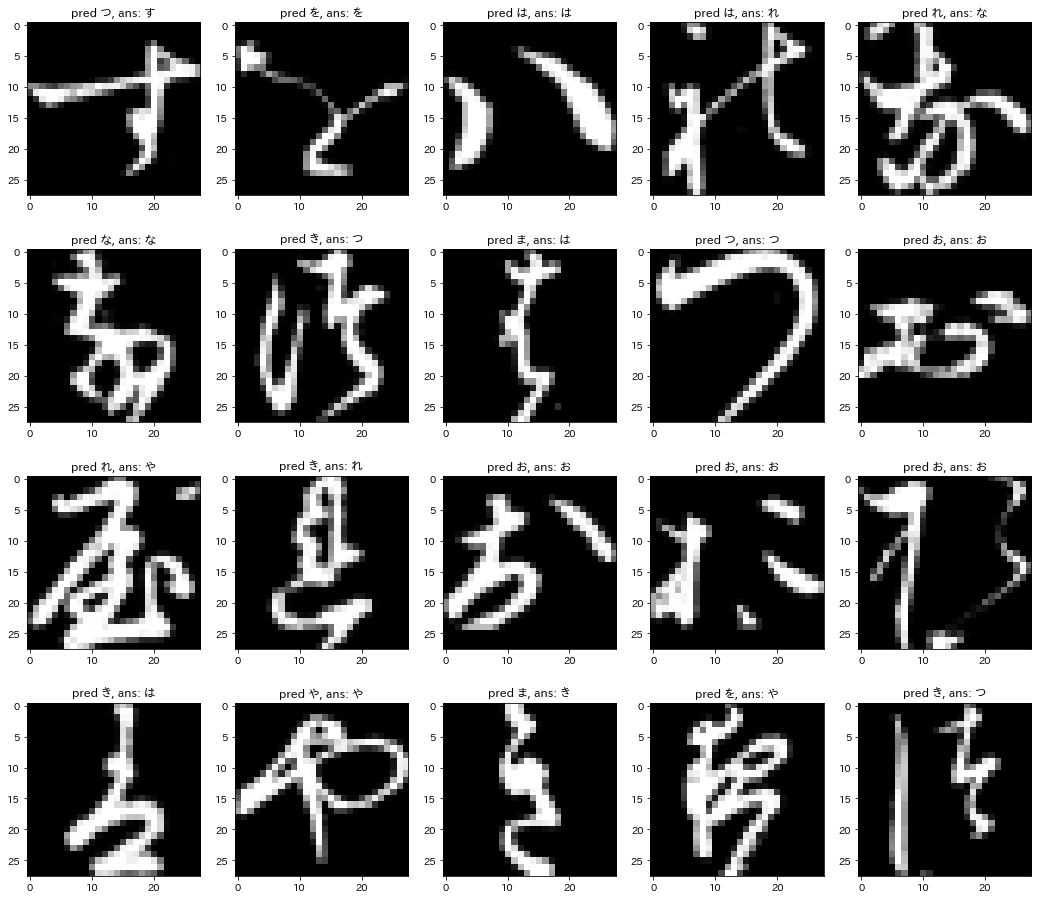

In [37]:
nrows, ncols = 4, 5
fig, ax = plt.subplots(nrows, ncols, figsize=(18, 16))
for i in range(nrows * ncols):
    ax[i // ncols, i % ncols].imshow(
        X_test[i].reshape(X_test[i].shape[:2]), cmap='gray')
    title = f"pred {classes[int(y_pred[i])]}, ans: {classes[y_test[i]]}"
    ax[i // ncols, i % ncols].set_title(title)
fig.show()

Delete the model deployed to endpoint if necessary.

In [38]:
DELETE_ENDPOINT = SETTINGS['instance']['endpoint']['delete']

In [39]:
if DELETE_ENDPOINT:
    SESS.delete_endpoint(predictor.endpoint)